# PV output analysis


In [1]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_yearly
import matplotlib.pyplot as plt
import seaborn as sns
import pvlib
from sklearn.metrics import mean_absolute_error, root_mean_squared_error  

## Solar PV Output Data

In a separate notebook we used local weather data and the PVLIB libary to estimate the output of a solar panel in Fresno California. This gives us 24 years of hourly observations.  It would be better to have actually measured solar output data, but it's very hard to find data series this long.  In a [China data notebook]() we showed that PVLIB predicted output matched actual output very well. 

We load the Fresno data, which measures hourly PV output in Watts, and plot it to analyze some characteristics.

In [2]:
file_path = "./data/daily_output.CSV"
df = pd.read_csv(file_path)
df['0'] = df['0'].astype('float32')
df.index = pd.to_datetime(df['datetime'])
df.rename(columns={ '0': 'y', 'datetime':'ds'}, inplace=True)
df['y'] = df['y'].where(df['y'] >= 0, 0)
print(df.y.describe().round(1))

count    9131.0
mean     2686.5
std       935.3
min         0.0
25%      2355.5
50%      3089.3
75%      3321.3
max      3912.2
Name: y, dtype: float64


Solar irradiance and PV output is highly variable.  Below is the daily power output (in watts) at the same location over each of three years.  We can observe seasonal patterns but also highly variable output.

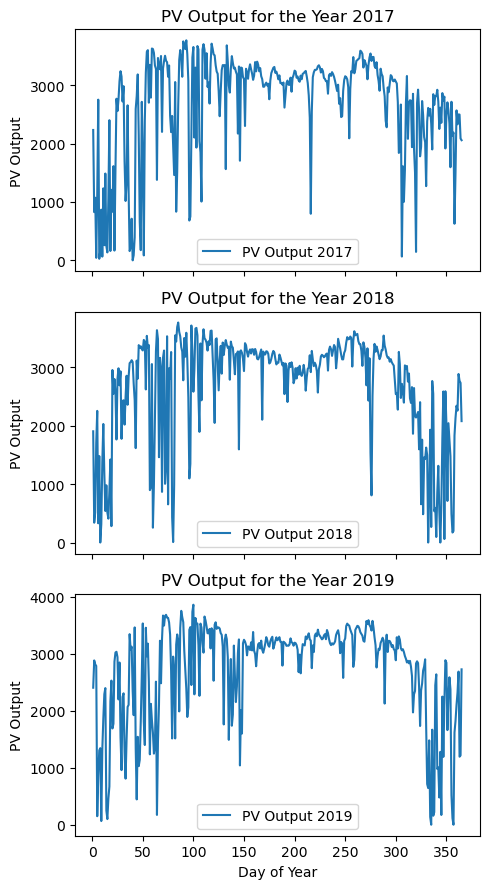

In [3]:
# Add a 'day_of_year' column to the dataframe
df['day_of_year'] = df.index.dayofyear

# Filter the dataframe for the years 2017, 2018, and 2019
df_2017 = df.loc['2017']
df_2018 = df.loc['2018']
df_2019 = df.loc['2019']

# Plot the 'y' values over time for 2017, 2018, and 2019 on vertically stacked subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 9), sharex=True)

axs[0].plot(df_2017['day_of_year'], df_2017['y'], label='PV Output 2017')
axs[0].set_title('PV Output for the Year 2017')
axs[0].set_ylabel('PV Output')
axs[0].legend()

axs[1].plot(df_2018['day_of_year'], df_2018['y'], label='PV Output 2018')
axs[1].set_title('PV Output for the Year 2018')
axs[1].set_ylabel('PV Output')
axs[1].legend()

axs[2].plot(df_2019['day_of_year'], df_2019['y'], label='PV Output 2019')
axs[2].set_title('PV Output for the Year 2019')
axs[2].set_xlabel('Day of Year')
axs[2].set_ylabel('PV Output')
axs[2].legend()

plt.tight_layout()
plt.show()
# Add a 'month' column to the dataframe
df['month'] = df.index.month

Here is a histogram of all the daily values over the 24 years.

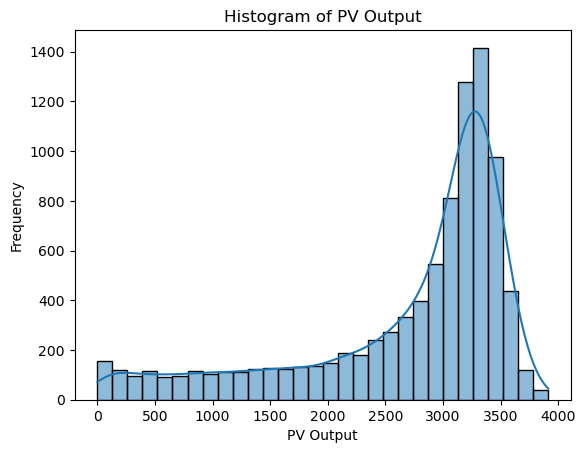

In [4]:
df.drop(columns=['day_of_year', 'month'], inplace=True)
sns.histplot(df['y'], bins=30, kde=True)
plt.xlabel('PV Output')
plt.ylabel('Frequency')
plt.title('Histogram of PV Output')
plt.show()

We can see however that the level and variance changes with the season. We will have to deal with this in our analysis.

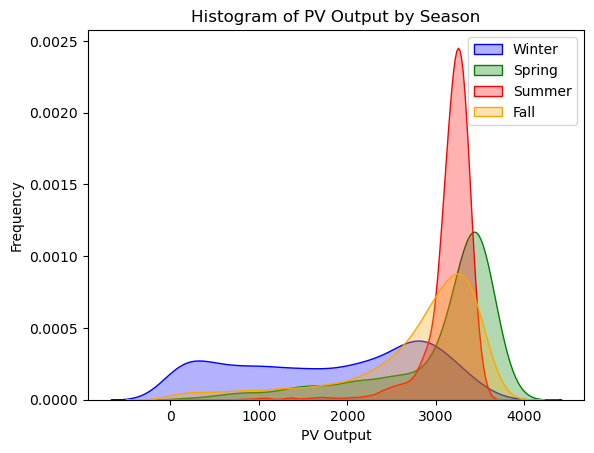

In [5]:
# Define the seasons
winter_months = [12, 1, 2]
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
fall_months = [9, 10, 11]

# Filter the dataframe for each season
df_winter = df[df.index.month.isin(winter_months)]
df_spring = df[df.index.month.isin(spring_months)]
df_summer = df[df.index.month.isin(summer_months)]
df_fall = df[df.index.month.isin(fall_months)]

# Plot KDE plots for each season
sns.kdeplot(df_winter['y'], color='blue', label='Winter', fill=True, alpha=0.3)
sns.kdeplot(df_spring['y'], color='green', label='Spring', fill=True, alpha=0.3)
sns.kdeplot(df_summer['y'], color='red', label='Summer', fill=True, alpha=0.3)
sns.kdeplot(df_fall['y'], color='orange', label='Fall', fill=True, alpha=0.3)


plt.xlabel('PV Output')
plt.ylabel('Frequency')
plt.title('Histogram of PV Output by Season')
plt.legend()
plt.show()

## Clear Sky Solar Irradiance
Extraterrestrial irradiance is the solar radiation received outside the Earth's atmosphere on a surface perpendicular to the Sun's rays. It is a fundamental component in calculating clearsky irradiance, which is the solar radiation received at the Earth's surface under clear sky conditions.

The pvlib library can calculate this for any position on earth given latitude, longitude, altitude, and time.  We will calculate hourly data and then resample to daily data.

Notice the very predictable seasonal component it generates.  Actual solar output will be less than this due to clouds, dust, and other factors, but we can see that the seasonal component is very strong.

In [6]:
latitude = 36.73  # Fresno
longitude = -119.78
altitude = 93  # meters

# we will measure every 30 minutes and later calculate daily average
time = pd.date_range(start='1998-01-01', end='2022-12-31', freq='30min', tz='America/Los_Angeles')

# Get solar position
solpos = pvlib.solarposition.get_solarposition(
    time=time,
    latitude=latitude,
    longitude=longitude,
    altitude=altitude,
)

# Calculate clear sky irradiance using the Ineichen model
clear_sky = pvlib.clearsky.ineichen(
    solpos['apparent_zenith'],
    solpos['azimuth'],
    linke_turbidity=3,  # You can adjust this turbidity value
    altitude=altitude,
)


ghi = clear_sky['ghi'].resample('D').mean()
dni = clear_sky['dni'].resample('D').mean()
dhi = clear_sky['dhi'].resample('D').mean()

df['ghi'] = ghi.values


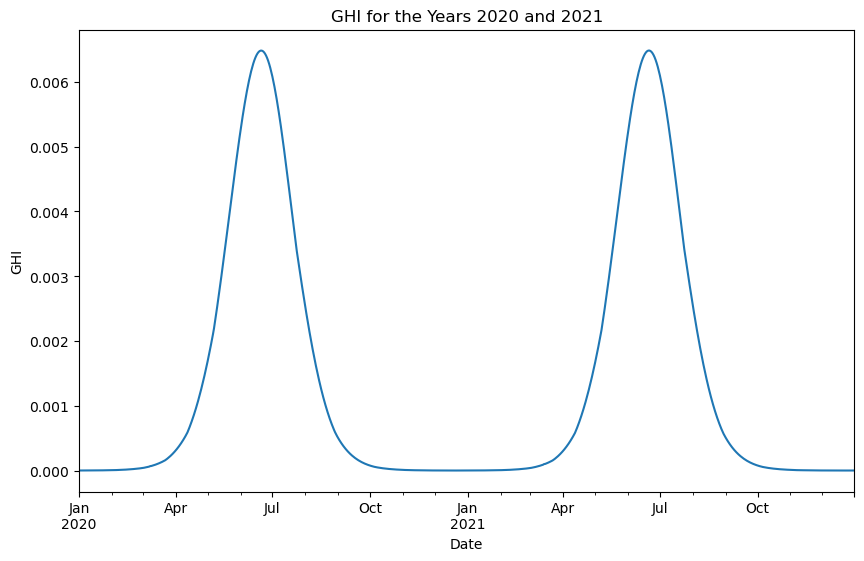

In [7]:
# Filter GHI for the years 2020 and 2021
ghi_2020_2021 = ghi['2020':'2021']

# Plot the GHI for 2020 and 2021
plt.figure(figsize=(10, 6))
ghi_2020_2021.plot()
plt.title('GHI for the Years 2020 and 2021')
plt.xlabel('Date')
plt.ylabel('GHI')
plt.show()